# Spatio-Temporal Traffic Forecasting with Neural Graph Cellular Automata
Petrônio C.  L. Silva  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Omid Orang  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-4077-3775" href="https://orcid.org/0000-0002-4077-3775" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Lucas Astore, Frederico G. Guimarães <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-9238-8839" href="https://orcid.org/0000-0001-9238-8839" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>

In case you have any questions, do not hesitate in contact us using the following e-mail: petronio.candido@ifnmg.edu.br


## Imports

In [1]:
from datetime import datetime, timezone, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.manifold import SpectralEmbedding

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from tensordict import TensorDict

from st_nca.common import get_device, resume, checkpoint
from st_nca.datasets import PEMS03, SensorDataset
from st_nca.cellmodel import CellModel
from st_nca.pretrain import training_loop
from st_nca.gca import GraphCellularAutomata

from st_nca.embeddings.temporal import from_datetime_to_pd

## Data

In [2]:
DEVICE = get_device()
DTYPE = torch.float32

DEFAULT_PATH = 'C:\\Users\\petro\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\st_nca\\st_nca\\'

DATA_PATH = DEFAULT_PATH + 'data\\PEMS03\\'

edges_file = DATA_PATH + 'edges.csv'
nodes_file = DATA_PATH + 'nodes.csv'
data_file = DATA_PATH + 'data.csv'

pems = PEMS03(edges_file=edges_file, nodes_file=nodes_file, data_file=data_file,
              dtype = DTYPE, device = DEVICE)

c:\Users\petro\Dropbox\Projetos\futurelab\posdoc\st_nca\st_nca\st_nca\embeddings\normalization.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=self.dtype, device=self.device)


(358, 2)


## Cell Model Training

KeyboardInterrupt: 

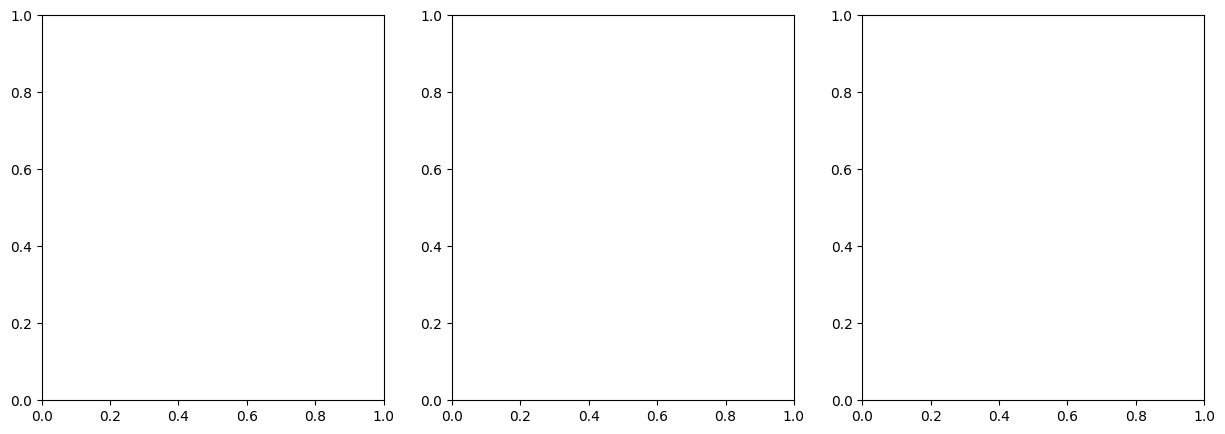

In [ ]:
NTRANSF = 2
NHEADS = 4
NTRANSFF = 256
TRANSFACT = nn.GELU()
MLP = 2
MLPD = 256
MLPACT = nn.GELU()

MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS03\\'

#ds = pems.get_fewsensors_dataset([311930, 312564, 312807, 312900, 313172, 314697, 315938, 317141, 318135, 318443 ], dtype=torch.float32, behavior='selfsupervised')
#ds = pems.get_sensor_dataset(311930, dtype=torch.float32, behavior='nondeterministic')
#ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
#                                       dtype=DTYPE,
#                                       behavior='selfsupervised')

ds = pems.get_allsensors_dataset(behavior='selfsupervised')

ds = ds.to(DEVICE)

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               use_moe = False, num_experts = 8,
               device = DEVICE, dtype = DTYPE)

training_loop(DEVICE, ds, cm,  batch=4096, epochs=10, lr=0.0001,
              checkpoint_file= MODELS_PATH + 'cell_model_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

In [ ]:
pems.num_samples

## Graph CA

In [ ]:
MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS03\\'

DTYPE = torch.float32
NTRANSF = 2
NHEADS = 4
NTRANSFF = 256
TRANSFACT = nn.GELU()
MLP = 2
MLPD = 256
MLPACT = nn.GELU()

ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=torch.float64,
                                       behavior='deterministic')

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               device = DEVICE, dtype = DTYPE)

resume(cm, MODELS_PATH + 'cell_model_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

subgraph = pems.G.subgraph(sensors)

gca = GraphCellularAutomata(device=cm.device, dtype=cm.dtype, graph = subgraph,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = cm)

initial_date = datetime(year=2018, month=9, day=1, hour=23, minute=0)

df = pems.data[(pems.data['timestamp'] == from_datetime_to_np(initial_date))]

initial_state = {}
for sensor in subgraph.nodes():
    initial_state[str(sensor)] = df[str(sensor)].values[0]

print(initial_state)

gca.run(initial_date = initial_date, initial_stat = initial_state, 
        iterations = 10, increment_type='minute', increment=5,
        return_type = 'tensordict')



## Fine Tunning

In [ ]:
from st_nca.finetune import FineTunningDataset, finetune_loop

MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS03\\'

DTYPE = torch.float32
NTRANSF = 2
NHEADS = 4
NTRANSFF = 256
TRANSFACT = nn.GELU()
MLP = 2
MLPD = 256
MLPACT = nn.GELU()

ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=DTYPE,
                                       behavior='deterministic')

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               device = DEVICE, dtype = DTYPE)

resume(cm, MODELS_PATH + 'cell_model_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

subgraph = pems.G.subgraph(sensors)

gca = GraphCellularAutomata(device=DEVICE, dtype=DTYPE, graph = subgraph,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = cm)

finetune_ds = FineTunningDataset(pems, sensors, )

finetune_loop(DEVICE, finetune_ds, gca, 
              iterations = 10, increment_type='minute', increment=5,
              epochs = 10, batch = 50, lr = 0.0001,
              checkpoint_file =  MODELS_PATH + 'gca_{}_{}_{}_{}_{}.pt'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

In [ ]:
pems.num_samples